In [56]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from PIL import Image
from tensorflow.keras.optimizers import Adam
%matplotlib inline

In [57]:
data_dir = './podaci_klasifikacija'
train_path = './podaci_klasifikacija/Train'
test_path = './podaci_klasifikacija/Test'
IMG_HEIGHT = 30
IMG_WIDTH = 30
CHANNELS = 3
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [58]:
def load_data(data_dir):
    images = list()
    labels = list()
    for category in range(NUM_CATEGORIES):
        categories = os.path.join(data_dir, str(category))
        for img in os.listdir(categories):
            img = cv2.imread(os.path.join(categories, img))
            img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
            images.append(img)
            labels.append(category)
    return images, labels

In [59]:
def prepare_data(images,labels):
    images = np.array(images)
    images = images.reshape(-1, 30, 30, 3)
    labels = np.array(labels)
    return (images, labels)

In [60]:
images, labels = load_data(train_path)

In [61]:
X_prep, y_prep = prepare_data(images, labels)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=0.2, shuffle=True, random_state=42)

In [63]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,random_state=42)

In [64]:
print("Podaci")
print("------------------------------------------")
print("Trening:")
print("X:",X_train.shape)
print("y:",y_train.shape)
print("Validacijski:")
print("X:",X_validation.shape)
print("y:",y_validation.shape)
print("Test:")
print("X:",X_test.shape)
print("y:",y_test.shape)

Podaci
------------------------------------------
Trening:
X: (25093, 30, 30, 3)
y: (25093,)
Validacijski:
X: (6274, 30, 30, 3)
y: (6274,)
Test:
X: (7842, 30, 30, 3)
y: (7842,)


In [65]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)  
    img = img / 255
    return img

In [66]:
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))
X_train= X_train.reshape(-1,30,30,1)
X_validation= X_validation.reshape(-1,30,30,1)
X_test= X_test.reshape(-1,30,30,1)

In [67]:
aug = ImageDataGenerator(rotation_range=10,
                        zoom_range=0.15,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.15,
                        horizontal_flip=False,
                        vertical_flip=False,
                        fill_mode="nearest")

In [68]:
aug.fit(X_train)
batches = aug.flow(X_train, y_train,batch_size=20)
X_batch, y_batch = next(batches)

In [69]:
y_train = to_categorical(y_train, NUM_CATEGORIES)
y_validation = to_categorical(y_validation, NUM_CATEGORIES)
y_test = to_categorical(y_test, NUM_CATEGORIES)

In [70]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu", input_shape=(IMG_HEIGHT,IMG_WIDTH,1)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation="softmax"))

In [71]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 128)         73856     
                                                        

In [73]:
history = model.fit(aug.flow(X_train,y_train,batch_size=64),
                    epochs=20,
                    validation_data=(X_validation,y_validation),
                    shuffle=1)

Epoch 1/20


393/393 [==============================] - 16s 36ms/step - loss: 2.1417 - accuracy: 0.3970 - val_loss: 0.4396 - val_accuracy: 0.8690
Epoch 2/20
393/393 [==============================] - 14s 36ms/step - loss: 0.6779 - accuracy: 0.7872 - val_loss: 0.1137 - val_accuracy: 0.9681
Epoch 3/20
393/393 [==============================] - 14s 36ms/step - loss: 0.3879 - accuracy: 0.8782 - val_loss: 0.0556 - val_accuracy: 0.9820
Epoch 4/20
393/393 [==============================] - 14s 36ms/step - loss: 0.2863 - accuracy: 0.9112 - val_loss: 0.0423 - val_accuracy: 0.9876
Epoch 5/20
393/393 [==============================] - 14s 35ms/step - loss: 0.2260 - accuracy: 0.9301 - val_loss: 0.0373 - val_accuracy: 0.9876
Epoch 6/20
393/393 [==============================] - 14s 35ms/step - loss: 0.1724 - accuracy: 0.9440 - val_loss: 0.0234 - val_accuracy: 0.9917
Epoch 7/20
393/393 [==============================] - 14s 36ms/step - loss: 0.1489 - accuracy: 0.9533 - val_loss: 0.0197 - val_accurac

In [74]:
model.save('./modeli/model_1.h5')
model.save('./modeli/model_1.keras')

c:\Users\DT User3\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [81]:
loss, accuracy = model.evaluate(X_test, y_test)

print('Test podaci preciznost: ', accuracy * 100)
print('Test podaci gubitak: ', loss)

246/246 [==============================] - 1s 5ms/step - loss: 0.0077 - accuracy: 0.9973
Test podaci preciznost:  99.73220825195312
Test podaci gubitak:  0.007677935063838959


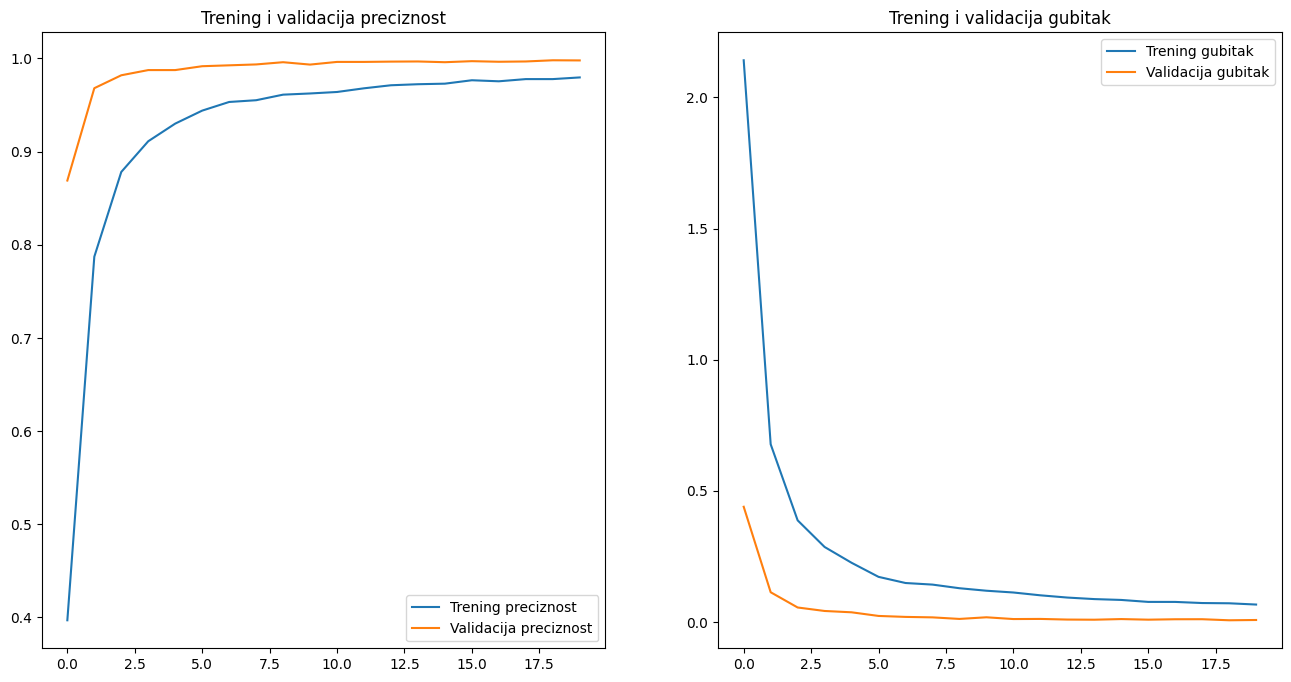

In [82]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Trening preciznost')
plt.plot(epochs_range, val_accuracy, label='Validacija preciznost')
plt.legend(loc='lower right')
plt.title('Trening i validacija preciznost')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Trening gubitak')
plt.plot(epochs_range, val_loss, label='Validacija gubitak')
plt.legend(loc='upper right')
plt.title('Trening i validacija gubitak')
plt.show()

In [85]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(Y_test,y_pred)

246/246 [==============================] - 1s 5ms/step


In [87]:
print("Konfuzijska matrica")
cm

Konfuzijska matrica


array([[ 37,   1,   0, ...,   0,   0,   0],
       [  0, 495,   1, ...,   0,   0,   0],
       [  0,   3, 445, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  60,   0,   0],
       [  0,   0,   0, ...,   0,  47,   0],
       [  0,   0,   0, ...,   0,   0,  41]], dtype=int64)

<Axes: >

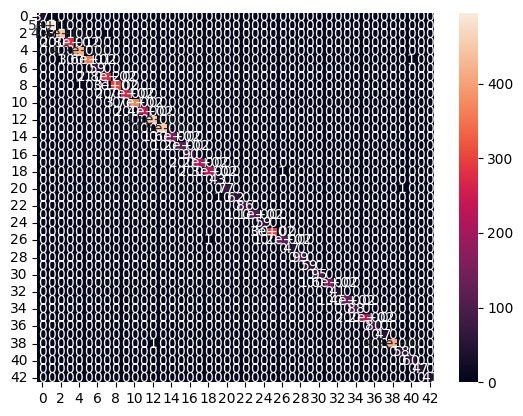

In [91]:
import seaborn as sns
sns.heatmap(cm, annot=True)

In [96]:
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test,y_pred)

In [97]:
score

0.9973221117061974

In [101]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.99      1.00      0.99       496
           2       1.00      0.99      0.99       450
           3       1.00      1.00      1.00       280
           4       1.00      1.00      1.00       418
           5       0.99      0.99      0.99       364
           6       1.00      1.00      1.00        59
           7       0.99      0.99      0.99       278
           8       0.99      0.99      0.99       301
           9       1.00      1.00      1.00       268
          10       1.00      1.00      1.00       370
          11       1.00      1.00      1.00       236
          12       1.00      1.00      1.00       450
          13       1.00      1.00      1.00       452
          14       1.00      1.00      1.00       162
          15       1.00      1.00      1.00       120
          16       1.00      1.00      1.00        90
          17       1.00    

In [102]:
val_pred = model.predict(X_validation)
y_validation = np.argmax(y_validation,axis=1)
val_predicted_labels = np.argmax(val_pred, axis = 1)
print(classification_report(y_validation,val_predicted_labels))

197/197 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.99      1.00      1.00       376
           2       1.00      0.99      1.00       338
           3       0.99      0.99      0.99       244
           4       1.00      0.99      1.00       302
           5       0.99      0.99      0.99       280
           6       1.00      1.00      1.00        63
           7       1.00      1.00      1.00       244
           8       1.00      1.00      1.00       214
           9       1.00      1.00      1.00       232
          10       1.00      1.00      1.00       303
          11       1.00      1.00      1.00       205
          12       1.00      1.00      1.00       325
          13       1.00      1.00      1.00       355
          14       1.00      1.00      1.00       145
          15       1.00      1.00      1.00       104
          16       1.00   